# 1. Cleanse
Look for null data in the table, and use the appropriate strategy to handle null data for each column. Explain why this was the strategy that you used.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

In [ ]:
application_train = pd.read_csv('/content/gdrive/MyDrive/application_train.csv')
application_train.head()

,SK_ID_CURR,Unnamed: 1,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,TARGET
0,100002,NaN,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,Laborers,1.0,0,0,0,0,0,0,Business Entity Type 3,1
1,100003,NaN,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,Core staff,2.0,0,0,0,0,0,0,School,0
2,100004,NaN,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,Laborers,1.0,0,0,0,0,0,0,Government,0
3,100006,NaN,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,Laborers,2.0,0,0,0,0,0,0,Business Entity Type 3,0
4,100007,NaN,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,Core staff,1.0,0,0,0,0,1,1,Religion,0


In [ ]:
application_train.info()

In [ ]:
application_train.shape

In [ ]:
application_train.isnull().sum()

In [ ]:
# Remove Unnamed: 1 since it all rows are NaN values
application_train = application_train.drop('Unnamed: 1', axis=1)
# Remove column NAME_TYPE_SUITE as this does not have any effect on the default
application_train = application_train.drop('NAME_TYPE_SUITE', axis=1)
# Age of the clients car may or may not help in assessing who defaults, but since around 66% of the data is missing, it would be better to remove this column
application_train = application_train.drop('OWN_CAR_AGE', axis=1)
# Gender of client "XNA". As we do not know the gender of the clients in these columns, their target number is 0 (hence, no default). We will drop these rows for this analysis:
application_train.drop(application_train[application_train['CODE_GENDER'] == 'XNA'].index, inplace=True)

In [ ]:
application_train['OCCUPATION_TYPE']
nan_rows = application_train[application_train['OCCUPATION_TYPE'].isna()]
#print(nan_rows)

# Occupation type can give us useful information on whether a person defaults, so we must keep this column. As a result, we delete the 96,391 rowws that have NaN values.
application_train = application_train.dropna(subset=['OCCUPATION_TYPE'])
#application_train = application_train.dropna(subset=['OCCUPATION_TYPE'], axis=0)


In [ ]:
application_train.isnull().sum()

In [ ]:
print(application_train.shape)

(211118, 34)


- Out of a total of 211120 rows, we now have 12 NaN values in AMT_ANNUITY, 221 NaN values in AMT_GOODS_PRICE and only 2 NaN values in CNT_FAM_MEMBERS.

- We can delete these rows, as it will not have a large impact on the shape of our final dataset.

We choose to keep these columns based on the following intuition:

- AMT_ANNUITY (Annuity of previous application) - Is an important factor and we need to keep it. The higher the annuity, the higher the chance of default.

- AMT_GOODS_PRICE (Goods price of good that client asked for (if applicable) on the previous application) - Is another important factor. The higher the value of the goods, the more likely they may be to default.

- CNT_FAM_MEMBERS (How many family members does client have) - May be an imoprtant factor since higher the number of family members, higher the cost of living and hence higher the chance of default.

In [ ]:
#Fill missing data with median values:
application_train['AMT_ANNUITY'].fillna(application_train['AMT_ANNUITY'].median(), inplace=True)
application_train['AMT_GOODS_PRICE'].fillna(application_train['AMT_GOODS_PRICE'].median(), inplace=True)
application_train['CNT_FAM_MEMBERS'].fillna(application_train['CNT_FAM_MEMBERS'].median(), inplace=True)
# Final dataset
application_train.shape
#application_train.info()
application_train.isnull().sum()

# 2. Outliers
Search the data for outliers and remove them. Use the appropriate outlier method(s).  Show all work.

In [ ]:
application_train.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,TARGET
count,211118.000000,211118.000000,2.111180e+05,2.111180e+05,211118.000000,2.111180e+05,211118.000000,211118.000000,211118.000000,211118.000000,...,211118.000000,211118.000000,211118.000000,211118.000000,211118.000000,211118.000000,211118.000000,211118.000000,211118.000000,211118.000000
mean,278222.581883,0.502913,1.757754e+05,6.103042e+05,27793.190576,5.480801e+05,-14763.506233,-2373.980035,-4625.493970,-2804.758074,...,0.276116,0.062486,2.260693,0.016749,0.060587,0.048461,0.090078,0.280942,0.218783,0.087851
std,102823.459664,0.764358,2.751427e+05,4.057500e+05,14621.690009,3.721643e+05,3643.729814,2593.668115,3242.145662,1515.406494,...,0.447076,0.242037,0.941184,0.128330,0.238572,0.214739,0.286294,0.449460,0.413422,0.283079
min,100002.000000,0.000000,2.565000e+04,4.500000e+04,1980.000000,4.050000e+04,-25200.000000,-17912.000000,-22928.000000,-7197.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189167.250000,0.000000,1.125000e+05,2.779695e+05,17077.500000,2.475000e+05,-17541.000000,-3164.000000,-6940.000000,-4181.000000,...,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278228.500000,0.000000,1.575000e+05,5.212800e+05,25839.000000,4.500000e+05,-14575.000000,-1641.000000,-4257.000000,-2892.000000,...,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,367367.500000,1.000000,2.115000e+05,8.248230e+05,35584.875000,6.885000e+05,-11789.000000,-767.000000,-1841.000000,-1492.000000,...,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,456255.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,-7489.000000,365243.000000,0.000000,0.000000,...,1.000000,1.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#Outlier 1: We see the max children a client has is 19 children - diving deepeer to understand this column:
application_train['CNT_CHILDREN'].value_counts()
# Assuming anything over 10 children could be a potential typo, we remove these values

application_train = application_train[application_train['CNT_CHILDREN'] < 10]

In [ ]:
#Outlier 2: Applying the IQR method
numerical_columns = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                      'AMT_GOODS_PRICE', 'DAYS_EMPLOYED',
                      'CNT_FAM_MEMBERS']

# Define a dictionary specifying the IQR multipliers for each numerical column
iqr_multipliers = {
    'AMT_INCOME_TOTAL': 3.0,
    'AMT_CREDIT': 2.0,
    'AMT_ANNUITY': 2.5,
    'AMT_GOODS_PRICE': 2.0,
    'DAYS_EMPLOYED': 3.0,
    'CNT_FAM_MEMBERS': 2.0,
}

# Create a new DataFrame to store the results without outliers
df_no_outliers_iqr = application_train.copy()

# Apply the IQR method for each specified column
for column in numerical_columns:
    Q1 = df_no_outliers_iqr[column].quantile(0.25)
    Q3 = df_no_outliers_iqr[column].quantile(0.75)
    IQR = Q3 - Q1

# Define the IQR multiplier for the current column
    iqr_multiplier = iqr_multipliers.get(column, 1.5)

# Filter outliers and update the DataFrame
    df_no_outliers_iqr = df_no_outliers_iqr[(df_no_outliers_iqr[column] >= Q1 - iqr_multiplier * IQR) &
                                            (df_no_outliers_iqr[column] <= Q3 + iqr_multiplier * IQR)]
print(df_no_outliers_iqr.describe())


          SK_ID_CURR   CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count  200406.000000  200406.000000     200406.000000  2.004060e+05   
mean   278262.207514       0.502695     166965.713907  5.748916e+05   
std    102860.006719       0.744478      76565.609132  3.526505e+05   
min    100002.000000       0.000000      25650.000000  4.500000e+04   
25%    189091.500000       0.000000     112500.000000  2.700000e+05   
50%    278295.000000       0.000000     157500.000000  5.084955e+05   
75%    367395.750000       1.000000     202500.000000  8.055360e+05   
max    456255.000000       4.000000     508500.000000  1.854504e+06   

         AMT_ANNUITY  AMT_GOODS_PRICE    DAYS_BIRTH  DAYS_EMPLOYED  \
count  200406.000000     2.004060e+05  200406.00000  200406.000000   
mean    26644.333096     5.140683e+05  -14648.22408   -2210.130984   
std     12783.525280     3.184134e+05    3607.33395    1990.628629   
min      1980.000000     4.050000e+04  -25180.00000  -10304.000000   
25%     16

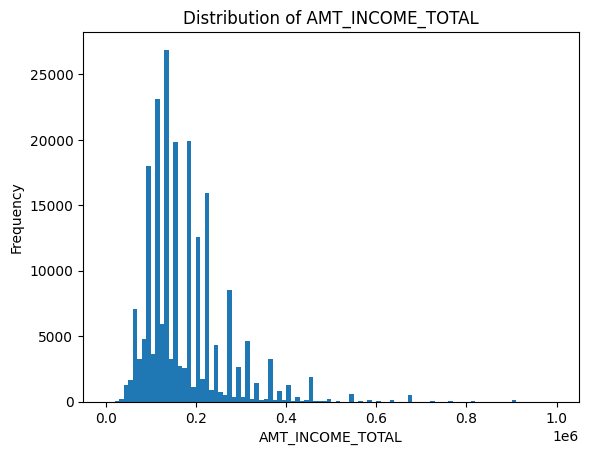

In [ ]:
x_min = 0
x_max = 1000000
plt.hist(application_train['AMT_INCOME_TOTAL'], bins=100, range=(x_min, x_max))
plt.xlabel('AMT_INCOME_TOTAL')
plt.ylabel('Frequency')
plt.title('Distribution of AMT_INCOME_TOTAL')
plt.show()

# 3 Exploratory Data Analysis

(a) How much (total) do they have out in loans?

(b) How much are in default/late?

(c) What percentage of the business are default and late?

(d) Along with the information above, provide three other demographics of their customers.

Remember, we are dealing with senior management. The charts must be readable, meaningful and at a summary level

Use at least one group/by or bin in your analysis

In [ ]:
# a. Total loan amount - Credit amount of the loan
total_loan_amt = application_train['AMT_CREDIT'].sum()
print(f"The total loan amount is: ${total_loan_amt:,}")

The total loan amount is: $128,842,048,984.5


 Total Amount in default/ late can be calculated using the TARGET column and the the AMT_CREDIT column in the following way:

 If the value in the TARGET column is 1, we add the corresponding entry in the AMT_CREDIT column until we have covered all the 1's in the TARGET column.

In [ ]:
# b. Total Amount in default/late can be calculated using the target col

total_default_amt = 0

# Iterate through the DataFrame
for index, row in application_train.iterrows():
    if row['TARGET'] == 1:
        total_default_amt += row['AMT_CREDIT']

# Print the total_default_amt
print(f"Total default amount:, ${total_default_amt:,}")

Total default amount:, $10,329,417,567.0


In [ ]:
print(f"The total percentage of defaults (in terms of loan amount) is: {round((total_default_amt/total_loan_amt),4)}%")

The total percentage of defaults (in terms of loan amount) is: 0.0802%


In [ ]:
# c. Using the target variable to identify the number and percent of defaults
application_train['TARGET'] = application_train['TARGET'].astype(int)
no_of_defaults = application_train['TARGET'].sum()
print(f"The total number of defaults  is: {no_of_defaults}")
percent_of_defaults = no_of_defaults/len(application_train['TARGET'])
print(f"The total percentage of defaults (in terms of number of loans) is: {round(percent_of_defaults,4)}%")

The total number of defaults  is: 18546
The total percentage of defaults (in terms of number of loans) is: 0.0878%


<Axes: title={'center': 'Demographic by Education Level'}, ylabel='Percentage'>

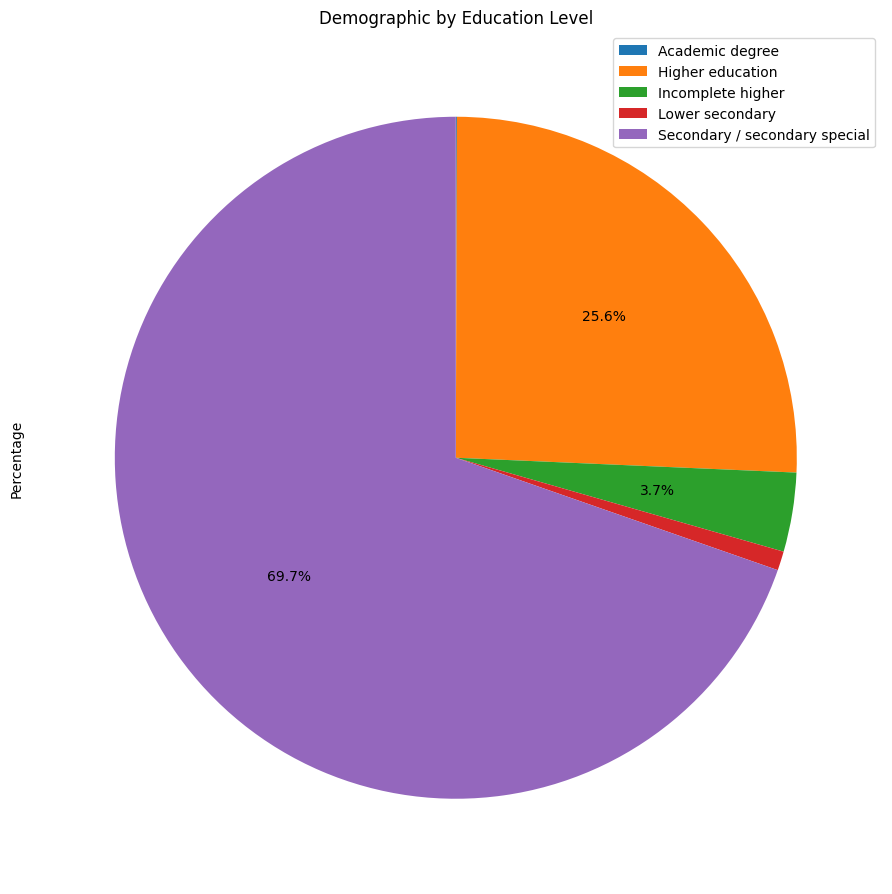

In [ ]:
#Demographic Distribution 1: EDUCATION TYPE
application_train_grp = application_train.groupby(['NAME_EDUCATION_TYPE']).size()
application_train_grp.plot(kind='pie',
                    title='Demographic by Education Level',
                    figsize=(11,20),
                    legend=True,
                    startangle=90, counterclock=False,
                    autopct=lambda p: '{:.1f}%'.format(p) if p > 1 else '',
                    label='Percentage',
                    labeldistance=1.1,
                    labels=None)

<Axes: title={'center': 'Demographic by Income Type'}, ylabel='Percentage'>

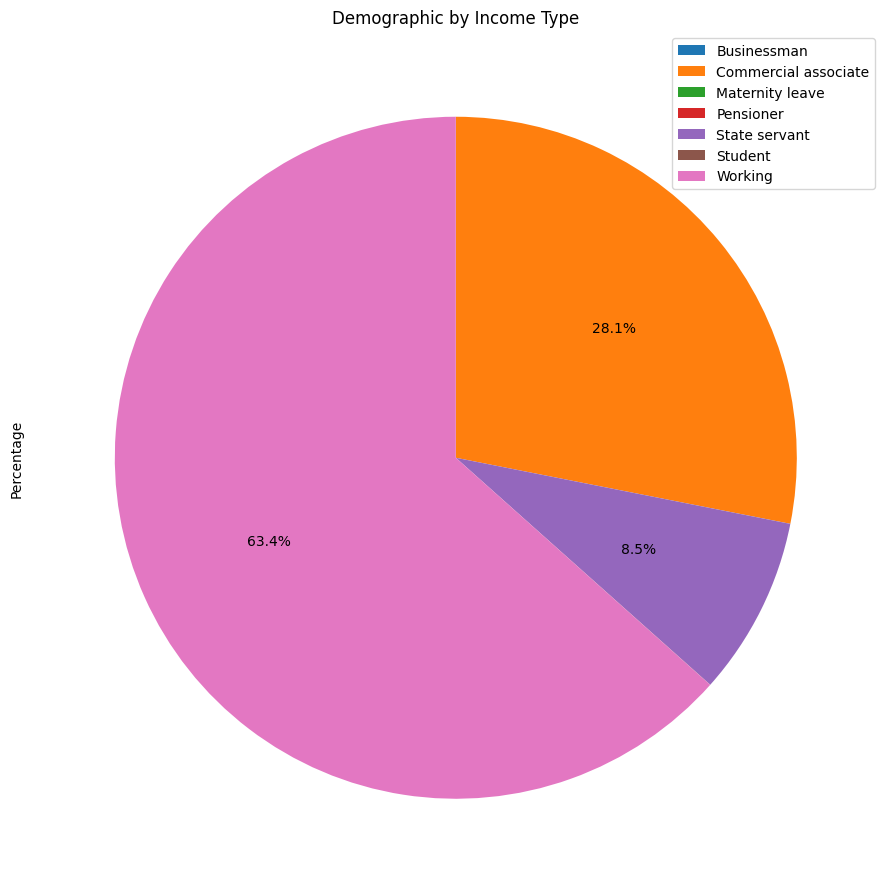

In [ ]:
#Demographic Distribution 2: INCOME TYPE
application_train_grp = application_train.groupby(['NAME_INCOME_TYPE']).size()
application_train_grp.plot(kind='pie',
                    title='Demographic by Income Type',
                    figsize=(11,20),
                    legend=True,
                    startangle=90, counterclock=False,
                    autopct=lambda p: '{:.1f}%'.format(p) if p > 1 else '',
                    label='Percentage',
                    labeldistance=1.1,
                    labels=None)

<Axes: title={'center': 'Demographic by Gender'}, ylabel='Percentage'>

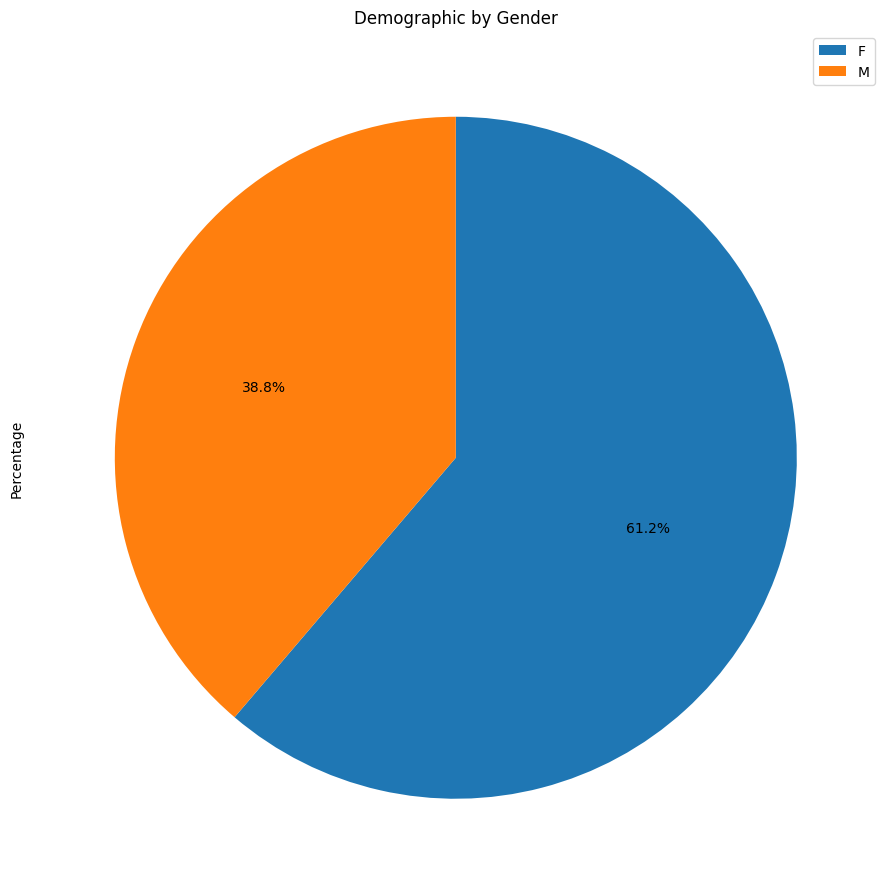

In [ ]:
#Demographic Distribution 3: CODE GENDER
application_train_grp = application_train.groupby(['CODE_GENDER']).size()
application_train_grp.plot(kind='pie',
                    title='Demographic by Gender',
                    figsize=(11,20),
                    legend=True,
                    startangle=90, counterclock=False,
                    autopct=lambda p: '{:.1f}%'.format(p) if p > 1 else '',
                    label='Percentage',
                    labeldistance=1.1,
                    labels=None)

<ipython-input-24-c8b4dfcded6c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = application_train.corr()


<Axes: >

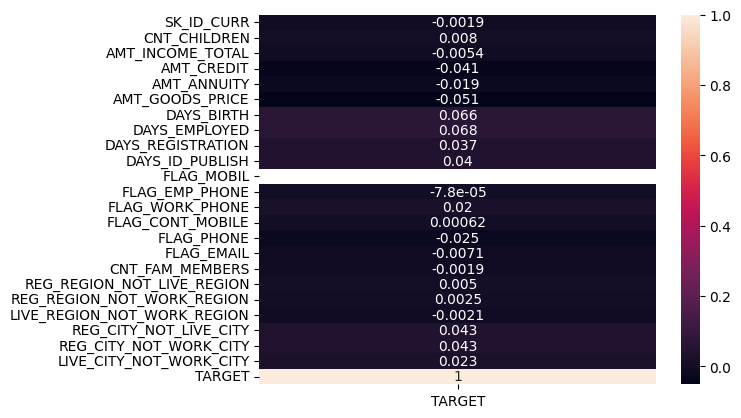

In [ ]:
corr_matrix = application_train.corr()
sns.heatmap(corr_matrix[['TARGET']], annot=True)

We note that no significant feature has a strong linear relationship with our target variable. However, the DAYS_BIRTH and DAYS_EMPLOYED features seem to have a slight positive correlation with the target variable.
(NOT REALLY USEFUL)

# 4 Who defaults or has problems replaying loans?

- Create visualizations to show management qualities specific to those who are in default/late.  Show three meaningful visualizations.

- Use at least one groupby or bin in your analysis.


Average annual income based on target (1 - Default/late and 0- No default/late): TARGET
0    176234.0
1    171009.0
Name: AMT_INCOME_TOTAL, dtype: float64


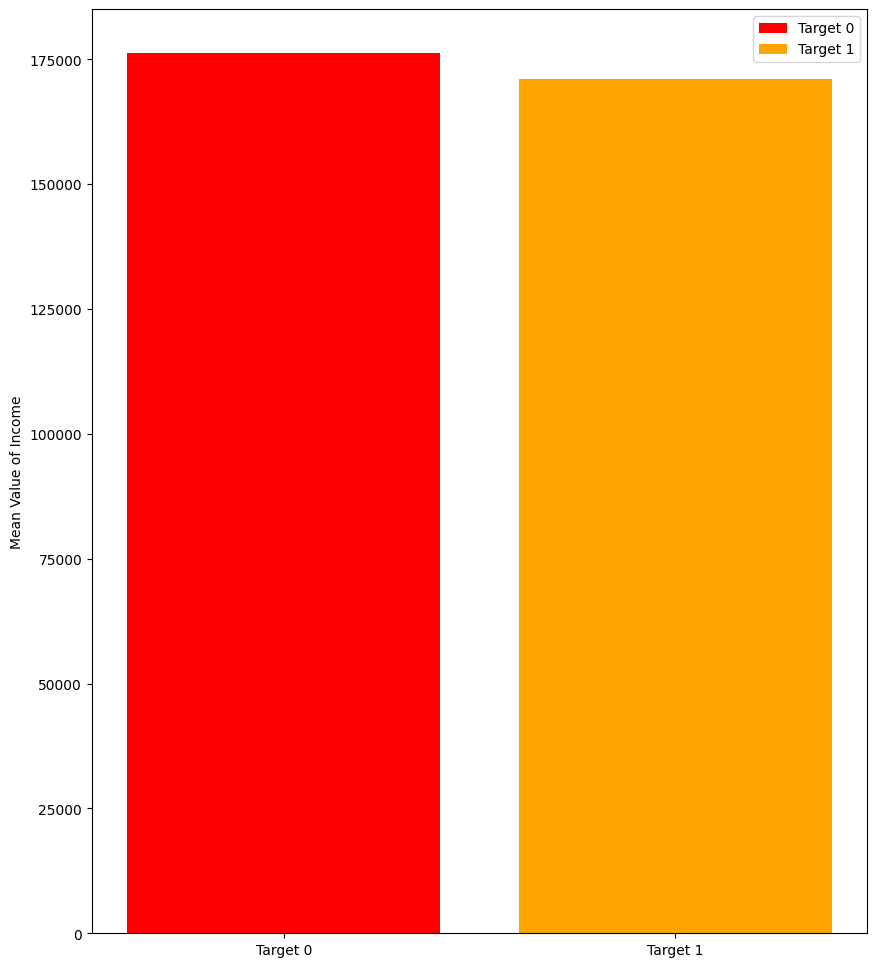

In [ ]:
#Visualization 1: Bar chart of average income of defaulters and non defaulters

avg_income_by_target = application_train.groupby('TARGET')['AMT_INCOME_TOTAL'].mean()
print(f"Average annual income based on target (1 - Default/late and 0- No default/late): {round(avg_income_by_target,0)}")

mean_value_0 = avg_income_by_target[0]
mean_value_1 = avg_income_by_target[1]
fig, ax = plt.subplots(figsize=(10, 12))
ax.bar(0, mean_value_0, color='r', label='Target 0')
ax.bar(1, mean_value_1, color='orange', label='Target 1')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Target 0', 'Target 1'])
ax.set_ylabel('Mean Value of Income')
ax.legend()
plt.show()

We notice that the income of the clients that are late or have defaulted is about $5,000 less than that of the clients that have not defaulted or made late payments.

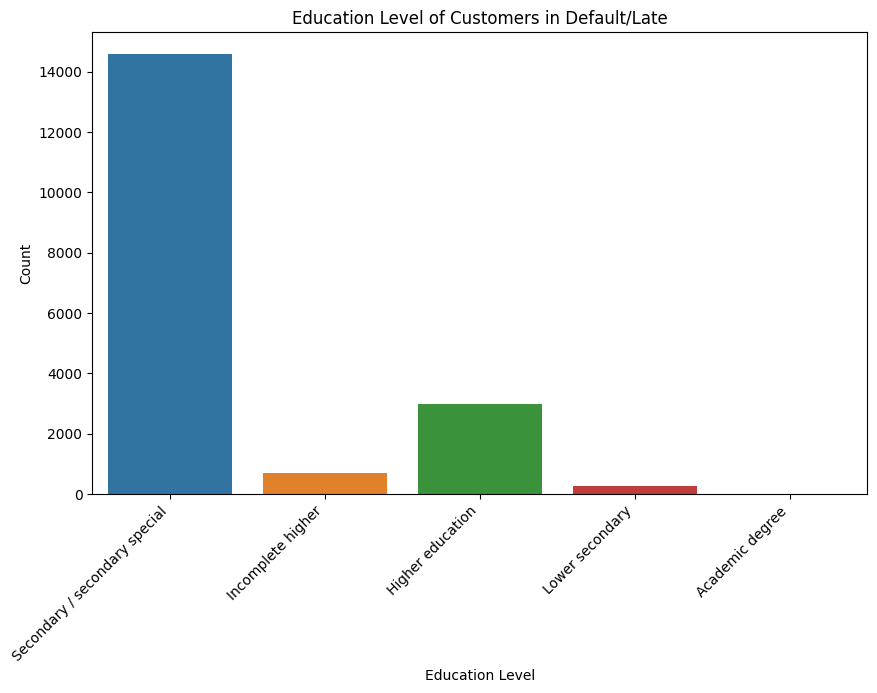

In [ ]:
#Filtering for clients who have defaulted
default_data = application_train[application_train['TARGET'] == 1]

#Visualization 2: Countplot of NAME_EDUCATION_TYPE for Default/Late Customers
plt.figure(figsize=(10, 6))
sns.countplot(x='NAME_EDUCATION_TYPE', data=default_data)
plt.title('Education Level of Customers in Default/Late')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

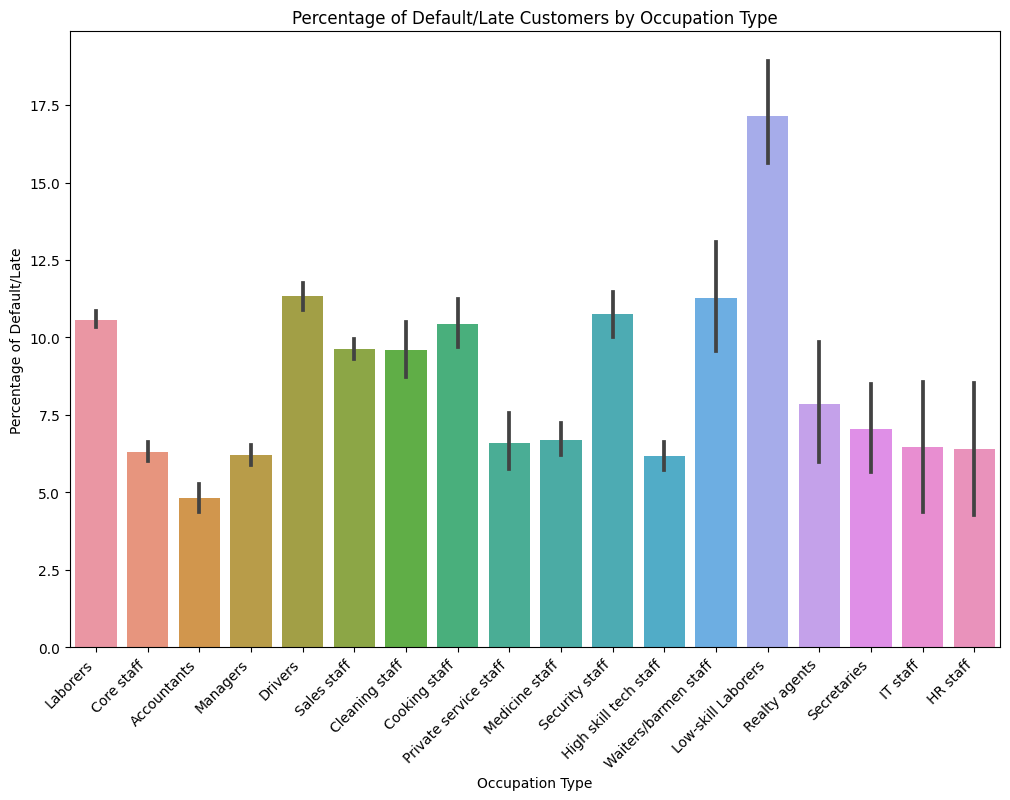

In [ ]:
#Visualization 3a: Barplot of OCCUPATION_TYPE for Default/Late Customers
plt.figure(figsize=(12, 8))
sns.barplot(x='OCCUPATION_TYPE', y='TARGET', data=application_train, estimator=lambda x: sum(x) / len(x) * 100)
plt.title('Percentage of Default/Late Customers by Occupation Type')
plt.xlabel('Occupation Type')
plt.ylabel('Percentage of Default/Late')
plt.xticks(rotation=45, ha='right')
plt.show()

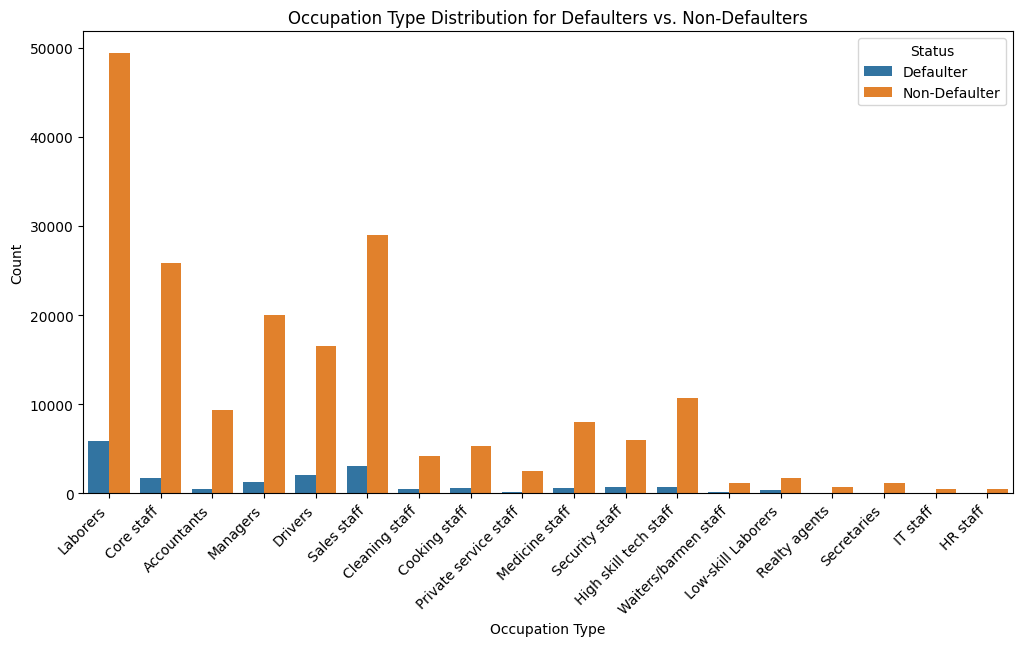

In [ ]:
# Visualization 3b: Employment Type Distribution for Defaulters vs. Non-Defaulters
plt.figure(figsize=(12, 6))
sns.countplot(data=application_train, x='OCCUPATION_TYPE', hue='Status')
plt.title('Occupation Type Distribution for Defaulters vs. Non-Defaulters')
plt.xlabel('Occupation Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


# 5 Prepare the data for a regression analysis


### Feature Selection

The ABC management team has heard that it might be possible to use their data to make predictions.  They don’t know much about data analytics. We are hoping that an example of what is possible will help them understand better.

Prepare the data file to run with a regression analysis.  Use the techniques and methods discussed in class.

In [ ]:
application_train = pd.get_dummies(application_train)
application_train.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,Status_Defaulter,Status_Non-Defaulter
0,100002,0,202500.0,406597.5,24700.5,351000.0,-9461,-637,-3648.0,-2120,...,0,0,0,0,0,0,0,0,1,0
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,-16765,-1188,-1186.0,-291,...,0,0,0,0,0,0,0,0,0,1
2,100004,0,67500.0,135000.0,6750.0,135000.0,-19046,-225,-4260.0,-2531,...,0,0,0,0,0,0,0,0,0,1
3,100006,0,135000.0,312682.5,29686.5,297000.0,-19005,-3039,-9833.0,-2437,...,0,0,0,0,0,0,0,0,0,1
4,100007,0,121500.0,513000.0,21865.5,513000.0,-19932,-3038,-4311.0,-3458,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Making our target column the last column
target_column_index = application_train.columns.get_loc("TARGET")
other_columns = [col for col in application_train.columns if col != "TARGET"]
new_column_order = other_columns + ["TARGET"]
application_train = application_train[new_column_order]
application_train.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,Status_Defaulter,Status_Non-Defaulter,TARGET
0,100002,0,202500.0,406597.5,24700.5,351000.0,-9461,-637,-3648.0,-2120,...,0,0,0,0,0,0,0,1,0,1
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,-16765,-1188,-1186.0,-291,...,0,0,0,0,0,0,0,0,1,0
2,100004,0,67500.0,135000.0,6750.0,135000.0,-19046,-225,-4260.0,-2531,...,0,0,0,0,0,0,0,0,1,0
3,100006,0,135000.0,312682.5,29686.5,297000.0,-19005,-3039,-9833.0,-2437,...,0,0,0,0,0,0,0,0,1,0
4,100007,0,121500.0,513000.0,21865.5,513000.0,-19932,-3038,-4311.0,-3458,...,0,0,0,0,0,0,0,0,1,0


# 6 Run the Logistic Regression analysis

Show scoring and a confusion matrix.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
def logisticreg(X,y):
  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  model = LogisticRegression(max_iter = 1000)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  conf_matrix = confusion_matrix(y_test, y_pred)
  accuracy = accuracy_score(y_test, y_pred)
  model.fit(X,y)
  model.score(X,y)
  mse = mean_squared_error(y_test, y_pred)
  print(f'Mean Squared Error: {mse}')
  print("Confusion Matrix:")
  cmtx = pd.DataFrame(
    conf_matrix,
    index=['actual:No Default', 'actual:Default'],
    columns=['pred:No Default', 'pred:Default']
)
  print(cmtx)
  print("\nAccuracy:",accuracy)

In [ ]:
# Separate the target variable from the features
a = application_train.iloc[:, :-1]
b = application_train.iloc[:, -1]

In [ ]:
logisticreg(a,b)

Mean Squared Error: 0.08883994126284875
Confusion Matrix:
                   pred:No Default  pred:Default
actual:No Default            38471             1
actual:Default                3750             0

Accuracy: 0.9111600587371512



# 7 XGBoost


eXtreme Gradient Boosting (XGBoost) is an ensemble learning method constructed from decision tree algorithms. XGBoost is an ensemble method, which means that it is a combination of multiple base models (multiple decision trees) in order to produce one optimal predictive model. There are different kinds of ensemble methods, among which bagging and boosting. XGBoost uses a gradient boosting framework. Meaning, the decision trees in XGBoost are grown in a sequential manner, as an iterative learning process: A first tree is trained and evaluated, after that the incorrect predicted data points are given more weightage in the next iteration. Then a next tree is trained and evaluated and the wrong predictions are given more weightage in the following iteration etc.

In [ ]:
from xgboost import XGBRegressor

In [ ]:
def XGBoost(X,y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  model = XGBRegressor()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  print(f"Mean Squared Error: {mse}")
  r2 = r2_score(y_test, y_pred)
  print(f"R-squared: {r2}")

In [ ]:
# Separate the target variable from the features
a = application_train.iloc[:, :-1]
b = application_train.iloc[:, -1]

In [ ]:
XGBoost(a,b)

Mean Squared Error: 4.809145211407213e-12
R-squared: 0.999999999940575
